In [1]:
import pycaret
pycaret.__version__

'3.0.0'

In [2]:
import hydra
from hydra import utils
from omegaconf import OmegaConf
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
cfg = OmegaConf.load('../../config/hdb_pre_processing.yaml')

print(cfg)

# Get Current Path
current_path =  os.getcwd()

# Change to parent path
parent_path = os.path.abspath(os.path.join(current_path, os.pardir))
# target_path = os.path.abspath(os.path.join(parent_path, os.pardir))

parent_path = os.path.abspath(os.path.join(parent_path, os.pardir))

print(parent_path)

{'dataset': {'raw_data': '/data/raw/01_hdb_resale_transactions.csv', 'processed_data': '/data/processed/01_resale_transactions.csv'}, 'features': {'drop_features': ['postal_code', 'year', 'month', 'street_name', 'lease_commence_date', 'block', 'town', 'resale_price'], 'numerical_features': ['latitude', 'longitude', 'cbd_dist', 'min_dist_mrt', 'remaining_lease', 'floor_area_sqm'], 'categorical_features': ['flat_type', 'storey_range', 'flat_model', 'region'], 'target_features': 'log_resale_price'}, 'setup': {'train_size': 0.8, 'test_size': 0.2, 'memory': 'None'}, 'file_location': {'generate_pkl': '/app/models/hdb_best_tuned_model'}}
C:\Users\parikshit joshi\Documents\GitHub\pycaret\notebooks\Assignment\MLOPS_ASSIGNMENT_GROUP2_TEAM6


In [4]:
## Read Data
df = pd.read_csv(parent_path  + cfg.dataset.raw_data)

# Show first 5 rows
df.head()

,block,street_name,town,postal_code,month,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,latitude,longitude,cbd_dist,min_dist_mrt
0,174,ANG MO KIO AVENUE 4,ANG MO KIO,560174,2015-01,3 ROOM,07 TO 09,60.0,Improved,1986,255000.0,1.375097,103.837619,10296.855750,1096.947897
1,541,ANG MO KIO AVENUE 10,ANG MO KIO,560541,2015-01,3 ROOM,01 TO 03,68.0,New Generation,1981,275000.0,1.373922,103.855621,10065.227930,847.235690
2,163,ANG MO KIO AVENUE 4,ANG MO KIO,560163,2015-01,3 ROOM,01 TO 03,69.0,New Generation,1980,285000.0,1.373552,103.838169,10118.831550,1176.742184
3,446,ANG MO KIO AVENUE 10,ANG MO KIO,560446,2015-01,3 ROOM,01 TO 03,68.0,New Generation,1979,290000.0,1.367761,103.855357,9383.300907,682.205473
4,557,ANG MO KIO AVENUE 10,ANG MO KIO,560557,2015-01,3 ROOM,07 TO 09,68.0,New Generation,1980,290000.0,1.371626,103.857736,9825.917255,953.047695


In [5]:
# Observe whether there is missing data or not.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194240 entries, 0 to 194239
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   block                194240 non-null  object 
 1   street_name          194240 non-null  object 
 2   town                 194240 non-null  object 
 3   postal_code          194240 non-null  int64  
 4   month                194240 non-null  object 
 5   flat_type            194240 non-null  object 
 6   storey_range         194240 non-null  object 
 7   floor_area_sqm       194240 non-null  float64
 8   flat_model           194240 non-null  object 
 9   lease_commence_date  194240 non-null  int64  
 10  resale_price         194240 non-null  float64
 11  latitude             194240 non-null  float64
 12  longitude            194240 non-null  float64
 13  cbd_dist             194240 non-null  float64
 14  min_dist_mrt         194240 non-null  float64
dtypes: float64(6), in

In [6]:
df['year'] = pd.to_datetime(df['month']).dt.year

In [7]:
df['remaining_lease'] = df['lease_commence_date'] + 99 - df['year']
df

,block,street_name,town,postal_code,month,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,latitude,longitude,cbd_dist,min_dist_mrt,year,remaining_lease
0,174,ANG MO KIO AVENUE 4,ANG MO KIO,560174,2015-01,3 ROOM,07 TO 09,60.0,Improved,1986,255000.0,1.375097,103.837619,10296.855750,1096.947897,2015,70
1,541,ANG MO KIO AVENUE 10,ANG MO KIO,560541,2015-01,3 ROOM,01 TO 03,68.0,New Generation,1981,275000.0,1.373922,103.855621,10065.227930,847.235690,2015,65
2,163,ANG MO KIO AVENUE 4,ANG MO KIO,560163,2015-01,3 ROOM,01 TO 03,69.0,New Generation,1980,285000.0,1.373552,103.838169,10118.831550,1176.742184,2015,64
3,446,ANG MO KIO AVENUE 10,ANG MO KIO,560446,2015-01,3 ROOM,01 TO 03,68.0,New Generation,1979,290000.0,1.367761,103.855357,9383.300907,682.205473,2015,63
4,557,ANG MO KIO AVENUE 10,ANG MO KIO,560557,2015-01,3 ROOM,07 TO 09,68.0,New Generation,1980,290000.0,1.371626,103.857736,9825.917255,953.047695,2015,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194235,362A,SEMBAWANG CRESCENT,SEMBAWANG,751362,2023-07,4 ROOM,16 TO 18,93.0,Model A,2019,560000.0,1.447195,103.814008,18624.123340,702.591563,2023,95
194236,362A,SEMBAWANG CRESCENT,SEMBAWANG,751362,2023-07,4 ROOM,04 TO 06,93.0,Model A,2019,550000.0,1.447195,103.814008,18624.123340,702.591563,2023,95
194237,366B,SEMBAWANG CRESCENT,SEMBAWANG,752366,2023-07,4 ROOM,13 TO 15,93.0,Model A,2019,565000.0,1.443922,103.815957,18223.416060,727.108165,2023,95
194238,992B,BUANGKOK LINK,HOUGANG,532992,2023-07,4 ROOM,07 TO 09,93.0,Model A,2019,598000.0,1.383827,103.881672,11650.037860,1278.633561,2023,95


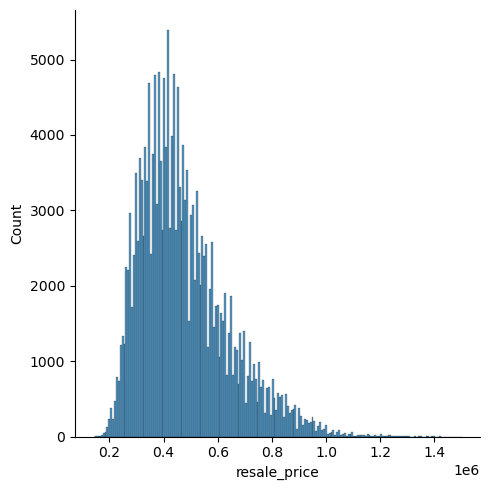

In [8]:
sns.displot(df['resale_price'])

## Binning town values to north,east,south, west

In [9]:
df['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

In [10]:
# Define the mapping of towns to regions
town_to_region = {
    'NORTH': ['SEMBAWANG', 'SENGKANG', 'WOODLANDS', 'YISHUN'],
    'EAST': ['BUKIT MERAH', 'BUKIT TIMAH', 'QUEENSTOWN'],
    'SOUTH': ['BEDOK', 'GEYLANG', 'HOUGANG', 'KALLANG/WHAMPOA', 'PASIR RIS', 'PUNGGOL', 'SERANGOON', 'TAMPINES'],
    'WEST': ['BUKIT BATOK', 'BUKIT PANJANG', 'CHOA CHU KANG', 'CLEMENTI', 'JURONG EAST', 'JURONG WEST'],
    'CENTRAL': ['ANG MO KIO', 'CENTRAL AREA', 'BISHAN', 'MARINE PARADE', 'TOA PAYOH'],
}

# Create a function to map town to region
def map_town_to_region(town):
    for region, towns in town_to_region.items():
        if town in towns:
            return region
    return 'UNKNOWN'  # Default value if not found

# Apply the mapping function to create a new column
df['region'] = df['town'].apply(map_town_to_region)


In [11]:
df['region'].unique()

array(['CENTRAL', 'SOUTH', 'WEST', 'EAST', 'NORTH'], dtype=object)

In [60]:
# Define the mapping of towns to regions
storey_range_to_categories = {
    '01 TO 10': ['01 TO 03', '04 TO 06','07 TO 09'],
    '10 TO 21': ['10 TO 12', '13 TO 15', '16 TO 18','19 TO 21'],
    '21 TO 30': ['22 TO 24', '25 TO 27', '28 TO 30'],
    '31 TO 39': ['31 TO 33', '34 TO 36', '37 TO 39'],
    '40 TO 51': ['40 TO 42', '43 TO 45', '46 TO 48', '49 TO 51'],
}

# Create a function to map town to region
def map_storey_range_to_categories(town):
    for region, towns in storey_range_to_categories.items():
        if town in towns:
            return region
    return 'UNKNOWN'  # Default value if not found

# Apply the mapping function to create a new column
df['storey_cat'] = df['storey_range'].apply(map_storey_range_to_categories)
df['storey_cat'].unique()

array(['01 TO 10', '10 TO 21', '21 TO 30', '31 TO 39', '40 TO 51'],
      dtype=object)

<Axes: xlabel='resale_price', ylabel='Count'>

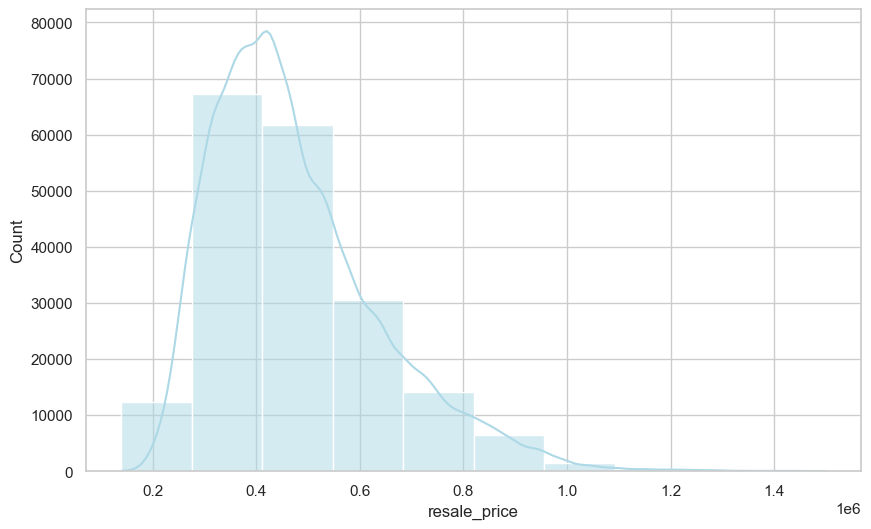

In [11]:
# Set up the seaborn style
sns.set(style="whitegrid")
# Create a histogram using sns.histplot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='resale_price', bins=10, kde=True, color='lightblue')


## a right-skewed distribution would look like below. We can observe deviation on the right side

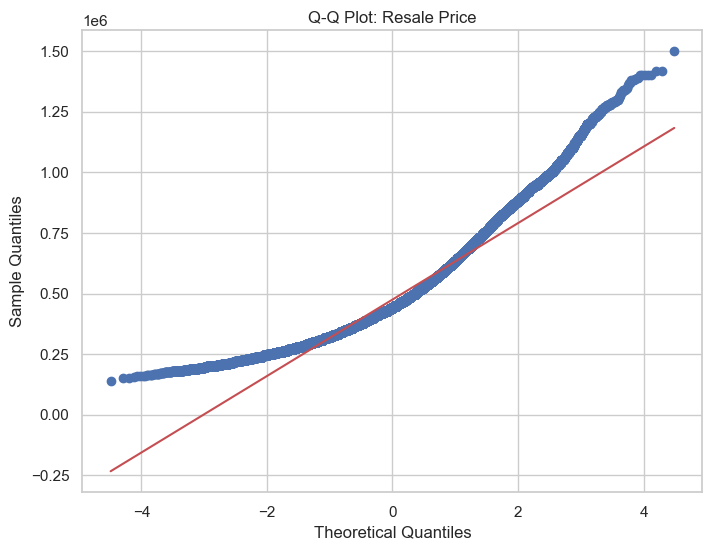

In [12]:
import scipy.stats as stats
# Set up the seaborn style
sns.set(style="whitegrid")

# Create a Q-Q plot using scipy.stats.probplot
plt.figure(figsize=(8, 6))
stats.probplot(df['resale_price'], plot=plt)

plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot: Resale Price')

plt.show()



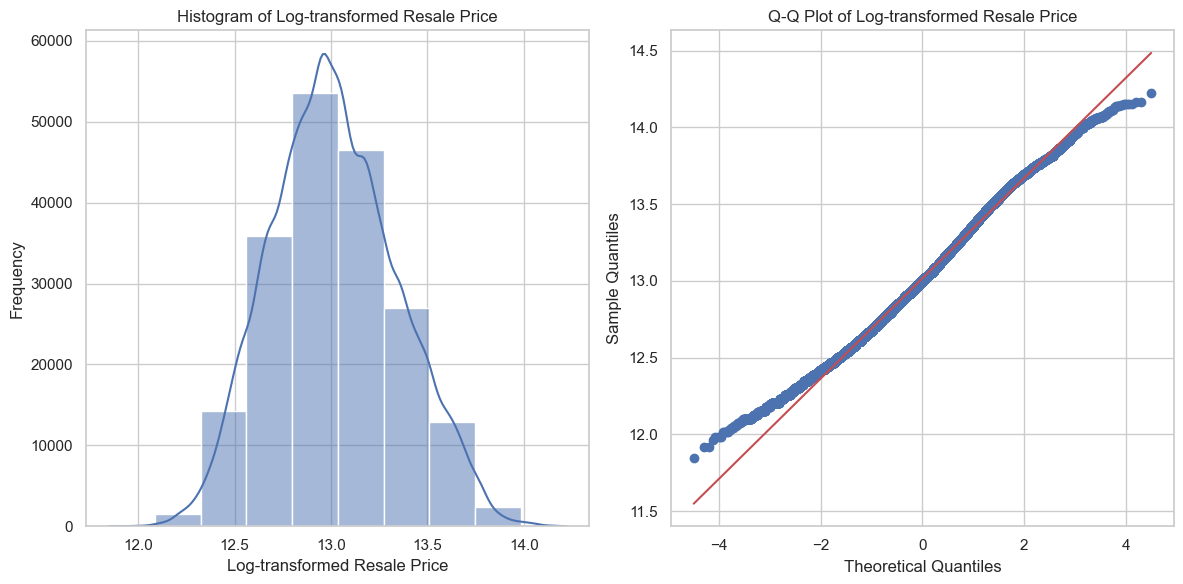

In [13]:
# Apply log transformation to the resale_price column
df['log_resale_price'] = np.log(df['resale_price'])

# Set up the seaborn style
sns.set(style="whitegrid")

# Create a histogram of the log-transformed resale_price
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='log_resale_price', bins=10, kde=True)
plt.xlabel('Log-transformed Resale Price')
plt.ylabel('Frequency')
plt.title('Histogram of Log-transformed Resale Price')

# Create a Q-Q plot of the log-transformed resale_price
plt.subplot(1, 2, 2)
stats.probplot(df['log_resale_price'], plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Log-transformed Resale Price')

plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'postal_code'}>,
        <Axes: title={'center': 'floor_area_sqm'}>,
        <Axes: title={'center': 'lease_commence_date'}>],
       [<Axes: title={'center': 'resale_price'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'longitude'}>],
       [<Axes: title={'center': 'cbd_dist'}>,
        <Axes: title={'center': 'min_dist_mrt'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'remaining_lease'}>,
        <Axes: title={'center': 'log_resale_price'}>, <Axes: >]],
      dtype=object)

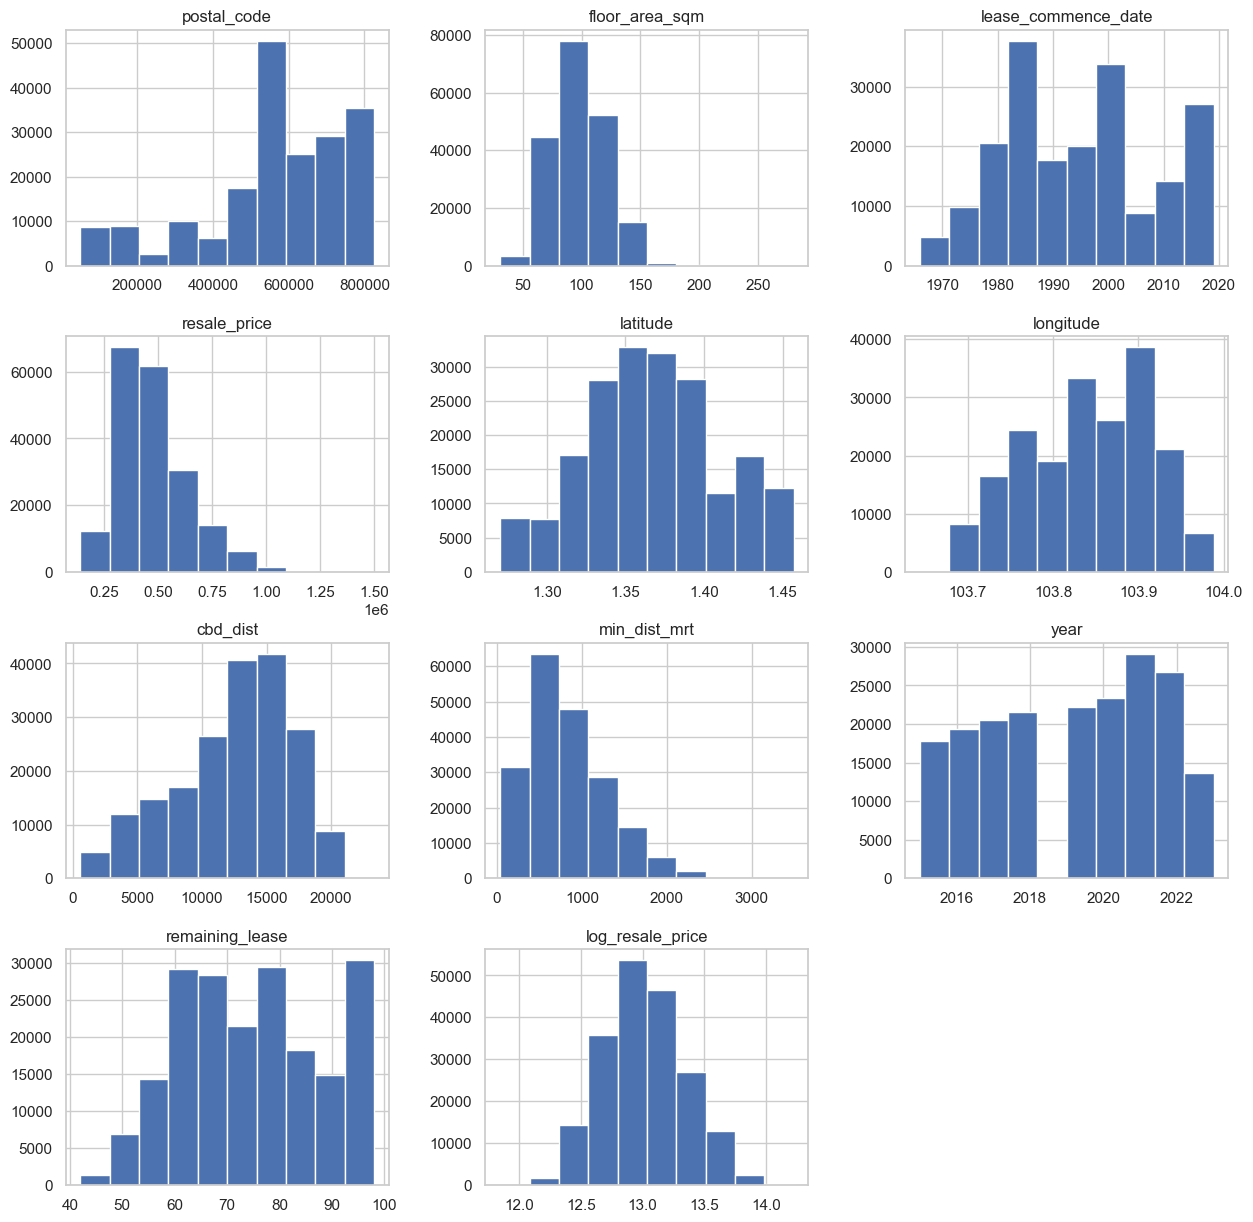

In [14]:
pd.DataFrame.hist(df,figsize=[15,15])

In [15]:
# In my analysis, I do not consider street name, block and  flat model is relevant for analysis as they are very unique values and we have latitude and longtitude to tell the same information. 
#as no description of impact of the address, e.g., near MRT or not). Some information in flat model are either similar 
#to room type (2 room, multi generation, etc.) or it reflected how old the unit is, which can be represented by 
#lease commence date and remaining lease.Therefore. I will drop this column for my analysis

df = df.drop(cfg.features.drop_features, axis=1)
df

,flat_type,storey_range,floor_area_sqm,flat_model,latitude,longitude,cbd_dist,min_dist_mrt,remaining_lease,region,log_resale_price
0,3 ROOM,07 TO 09,60.0,Improved,1.375097,103.837619,10296.855750,1096.947897,70,CENTRAL,12.449019
1,3 ROOM,01 TO 03,68.0,New Generation,1.373922,103.855621,10065.227930,847.235690,65,CENTRAL,12.524526
2,3 ROOM,01 TO 03,69.0,New Generation,1.373552,103.838169,10118.831550,1176.742184,64,CENTRAL,12.560244
3,3 ROOM,01 TO 03,68.0,New Generation,1.367761,103.855357,9383.300907,682.205473,63,CENTRAL,12.577636
4,3 ROOM,07 TO 09,68.0,New Generation,1.371626,103.857736,9825.917255,953.047695,64,CENTRAL,12.577636
...,...,...,...,...,...,...,...,...,...,...,...
194235,4 ROOM,16 TO 18,93.0,Model A,1.447195,103.814008,18624.123340,702.591563,95,NORTH,13.235692
194236,4 ROOM,04 TO 06,93.0,Model A,1.447195,103.814008,18624.123340,702.591563,95,NORTH,13.217674
194237,4 ROOM,13 TO 15,93.0,Model A,1.443922,103.815957,18223.416060,727.108165,95,NORTH,13.244581
194238,4 ROOM,07 TO 09,93.0,Model A,1.383827,103.881672,11650.037860,1278.633561,95,SOUTH,13.301346


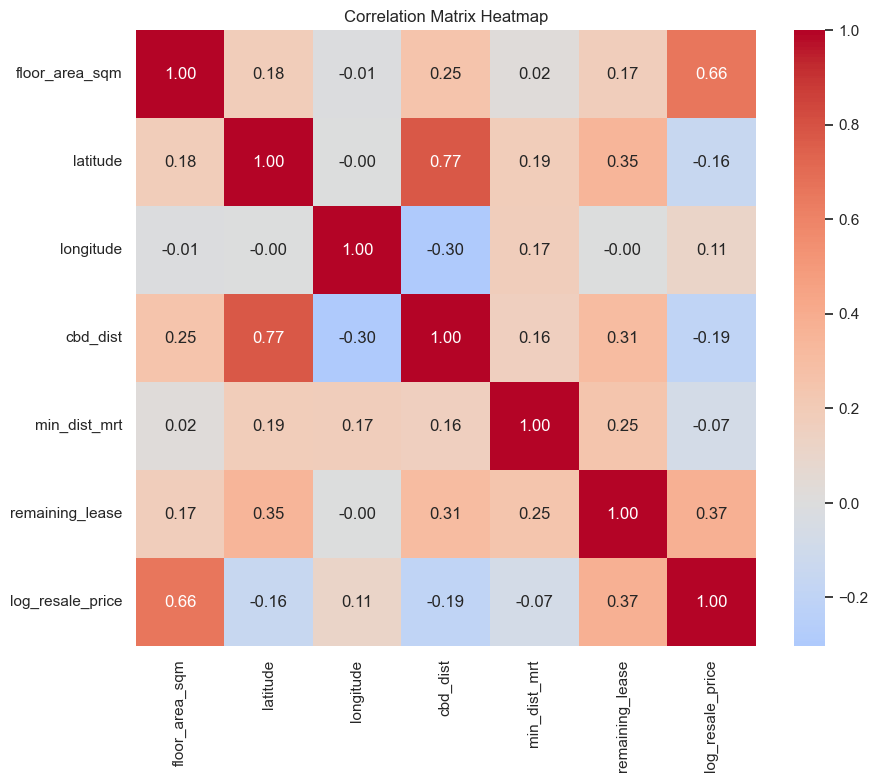

In [16]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Set up the seaborn style
sns.set(style="white")

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)

plt.title('Correlation Matrix Heatmap')
plt.show()

In [17]:
from pycaret.regression import *
s = setup(df, 
          target = cfg.features.target_features, 
          session_id = 123,
         numeric_features = cfg.features.numerical_features,
        categorical_features = cfg.features.categorical_features,
          remove_multicollinearity = True,
          normalize = True,
          train_size=cfg.setup.train_size,
          memory=cfg.setup.memory,
          log_experiment = True,
          experiment_name = 'hdb_model_run_5'
        )

,Description,Value
0,Session id,123
1,Target,log_resale_price
2,Target type,Regression
3,Original data shape,"(194240, 11)"
4,Transformed data shape,"(194240, 56)"
5,Transformed train set shape,"(155392, 56)"
6,Transformed test set shape,"(38848, 56)"
7,Numeric features,6
8,Categorical features,4
9,Preprocess,True


2023/08/21 18:43:20 INFO mlflow.tracking.fluent: Experiment with name 'hdb_model_run_gbr' does not exist. Creating a new experiment.


In [18]:
best_gbr=create_model('gbr')
best_gbr

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1018,0.0158,0.1256,0.8526,0.0090,0.0078
1,0.1022,0.0160,0.1264,0.8515,0.0090,0.0078
2,0.1029,0.0160,0.1267,0.8514,0.0090,0.0079
3,0.1025,0.0160,0.1263,0.8505,0.0090,0.0079
4,0.1022,0.0158,0.1257,0.8529,0.0090,0.0079
5,0.1027,0.0159,0.1260,0.8528,0.0090,0.0079
6,0.1028,0.0161,0.1269,0.8502,0.0090,0.0079
7,0.1016,0.0158,0.1259,0.8515,0.0090,0.0078
8,0.1018,0.0158,0.1258,0.8518,0.0090,0.0078


GradientBoostingRegressor(random_state=123)

In [ ]:
#best_models = compare_models(n_select=2) 

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:33:24
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,0.0623,0.0075,0.0866,0.9301,0.0062,0.0048,2.4970
knn,K Neighbors Regressor,0.0673,0.0082,0.0905,0.9236,0.0065,0.0052,18.5880
lr,Linear Regression,0.1238,0.0227,0.1508,0.7881,0.0108,0.0095,0.3550
ridge,Ridge Regression,0.1238,0.0227,0.1508,0.7881,0.0108,0.0095,1.1920
br,Bayesian Ridge,0.1238,0.0227,0.1508,0.7881,0.0108,0.0095,2.6650
huber,Huber Regressor,0.1229,0.0229,0.1512,0.7869,0.0108,0.0094,5.4990
omp,Orthogonal Matching Pursuit,0.1356,0.0277,0.1664,0.7421,0.0119,0.0104,1.4660
par,Passive Aggressive Regressor,0.1491,0.0346,0.1858,0.6776,0.0132,0.0114,2.1510
lasso,Lasso Regression,0.2643,0.1073,0.3276,-0.0002,0.0233,0.0203,0.9590
en,Elastic Net,0.2643,0.1073,0.3276,-0.0002,0.0233,0.0203,1.2750


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

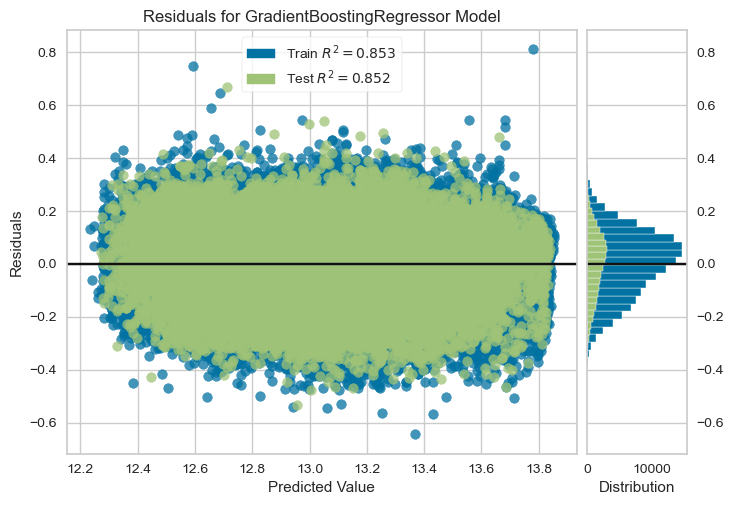

In [19]:
plot_model(best_gbr, plot = 'residuals')

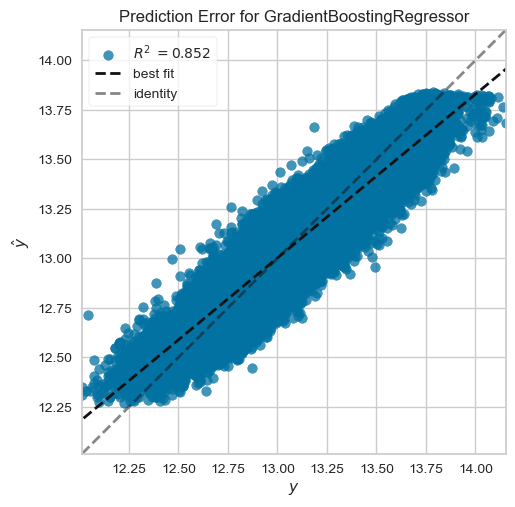

In [20]:
plot_model(best_gbr, plot = 'error')

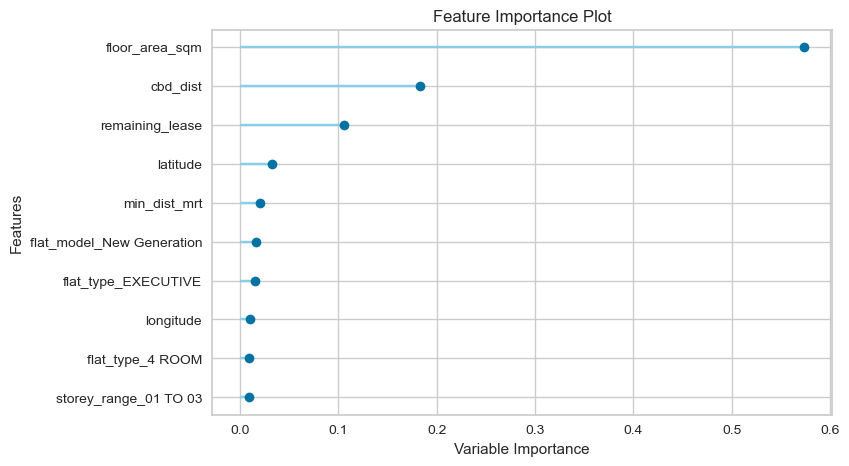

In [21]:
plot_model(best_gbr, plot = 'feature')

In [22]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [20]:
print(parent_path + cfg.file_location.generate_pkl)

C:\Users\parikshit joshi\Documents\GitHub\pycaret\notebooks\Assignment\MLOPS_ASSIGNMENT_GROUP2_TEAM6/app/models/hdb_best_tuned_model


In [20]:
save_model(best_gbr, parent_path + cfg.file_location.generate_pkl)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=None\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['latitude', 'longitude', 'cbd_dist', 'min_dist_mrt', 'remaining_lease', 'floor_area_sqm'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['flat_type', 'storey_range', 'flat_model', 'region'],
                                     transformer=SimpleImputer(str...
                                     transformer=OneHotEncoder(cols=['flat_type',
                                                                     'storey_range',
                                                                     'flat_model',
                                                                     'region'],
                                                               handle_missing='return_nan',
                                                               use_cat_n

In [38]:
#final_best = finalize_model(best_rf)

In [23]:
holdout_pred = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0481,0.0042,0.0647,0.9611,0.0046,0.0037
